# Model training and evaluation

## 1 Data Pre-processing

### Import libraries and packages

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
# Pre-processing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.compose import ColumnTransformer
# Modelling
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/ENB2012_data.csv')

In [3]:
df.head()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
0,0.98,514.5,294.0,110.25,7.0,2,0.0,0,15.55,21.33
1,0.98,514.5,294.0,110.25,7.0,3,0.0,0,15.55,21.33
2,0.98,514.5,294.0,110.25,7.0,4,0.0,0,15.55,21.33
3,0.98,514.5,294.0,110.25,7.0,5,0.0,0,15.55,21.33
4,0.90,563.5,318.5,122.50,7.0,2,0.0,0,20.84,28.28


### Preparing input X and output y

In [4]:
# define input and output
X = df.iloc[:, :-2] # 8 input variables
y1 = df.iloc[:, -2] # first output
y2 = df.iloc[:, -1] # second output

In [5]:
# create column transformer and preprocessing pipeline
num_features = X.select_dtypes(exclude="object").columns
cat_features = X.select_dtypes(include="object").columns # no categorical feature in the data set, if yes, we may use e.g. OneHotEncoder

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("normalize", MinMaxScaler()),
])

preprocessing = ColumnTransformer([
    ("num", num_pipeline, num_features)
])

In [6]:
# X_prepared = preprocessing.fit_transform(X)

In [7]:
# X_prepared.shape

### Perform train test set split

In [8]:
# divide the dataset as train and test sets
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y1, test_size=0.3, random_state=42)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, y2, test_size=0.3, random_state=42)

In [9]:
X_train1.head()

,X1,X2,X3,X4,X5,X6,X7,X8
334,0.62,808.5,367.5,220.5,3.5,4,0.25,1
139,0.64,784.0,343.0,220.5,3.5,5,0.10,2
485,0.90,563.5,318.5,122.5,7.0,3,0.25,5
547,0.79,637.0,343.0,147.0,7.0,5,0.40,1
18,0.79,637.0,343.0,147.0,7.0,4,0.00,0


In [10]:
y_train1.head()

334    15.08
139    15.19
485    32.31
547    41.67
18     29.63
Name: Y1, dtype: float64


## 2 Define model performance evaluation metrics
* Mean absolute error (MAE)
* Root mean squared error (RMSE)
* Mean absolute percentage error (MAPE)

In [11]:
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mape = mean_absolute_percentage_error(true, pred)

    return mae, rmse, mape

## 3 Model training and hyper-parameter tuning
* List of models include linear regression, support vector regression and random forest
* Use k-fold cross-validation to perform hyperparameter tuning

In [12]:
# create a dictionary of different models
models = {
    "linear_regression": LinearRegression(),
    "lasso": Lasso(),
    "ridge": Ridge(),
    "elastic_net": ElasticNet(),
    "support_vector_regressor": SVR(),
    "random_forest_regressor": RandomForestRegressor(random_state=42),
}


In [13]:
# create a list that stores all the hyper-parameters for all the models
param_grids = [
    {},
    {"lasso__alpha": [0.1, 0.2, 0.5, 1, 2, 5, 10, 20]},
    {"ridge__alpha": [0.1, 0.3, 1, 2, 5, 10, 20, 50, 100, 200]},
    {"elastic_net__alpha": [0.1, 0.3, 1, 3, 10],
     "elastic_net__l1_ratio": [1, 3, 10, 30, 100]},
    {"svr__kernel": ['linear', 'poly', 'rbf', 'sigmoid'],
     "svr__C": [0.1, 1, 10, 100],
     "svr__epsilon": [0.01, 0.1, 1]},
    {"random_forest__n_estimators": [10, 30, 100, 300],
     "random_forest__max_depth": [3, 4, 5, 6],
     "random_forest__min_samples_split": [2, 3, 4, 5],
     "random_forest__max_features": ['sqrt', 'log2']},
]

In [14]:
model_list = []
final_model1_list = []
final_model2_list = []
mape1_list =[]
mape2_list = []

for i in range(len(list(models))):
    model = list(models.values())[i]
    param_grid = param_grids[i]
    if len(param_grid.keys())==0:
        model_name = "reg"
    else:
        first_hyperparam = list(param_grid.keys())[0]
        model_name = first_hyperparam.split("__")[0] # get the model name so that scikit-learn pipeline can recognize the hyperparams

    # build the full pipeline fropm preprocessing to model training
    full_pipeline = Pipeline([
        ('preprocessing', preprocessing),
        (model_name, model)
    ])

    # hyperparameter tuning using GridSearch cross-validation
    grid_search = GridSearchCV(full_pipeline, param_grid=param_grid, cv=5)

    # Train model and make predictions for y1
    grid_search.fit(X_train1, y_train1) # Train model
    final_model1 = grid_search.best_estimator_ # include pre-processing
    final_model1_list.append(final_model1) 
    y_train1_pred = grid_search.predict(X_train1)
    y_test1_pred = grid_search.predict(X_test1)

    # Train model and make predictions for y2
    grid_search.fit(X_train2, y_train2) # Train model
    final_model2 = grid_search.best_estimator_ # include pre-processing
    final_model2_list.append(final_model2) 
    y_train2_pred = grid_search.predict(X_train2)
    y_test2_pred = grid_search.predict(X_test2)
    
    # Evaluate Train and Test dataset
    model_train1_mae , model_train1_rmse, model_train1_mape = evaluate_model(y_train1, y_train1_pred)

    model_test1_mae , model_test1_rmse, model_test1_mape = evaluate_model(y_test1, y_test1_pred)

    model_train2_mae , model_train2_rmse, model_train2_mape = evaluate_model(y_train2, y_train2_pred)

    model_test2_mae , model_test2_rmse, model_test2_mape = evaluate_model(y_test2, y_test2_pred)
    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance (heating load) for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train1_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train1_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_train1_mape))

    print('----------------------------------')
    
    print('Model performance (heating load) for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test1_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test1_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_test1_mape))
    mape1_list.append(model_test1_mape)

    print('----------------------------------')

    print('Model performance (cooling load) for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train2_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train2_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_train2_mape))

    print('----------------------------------')
    
    print('Model performance (cooling load) for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test2_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test2_mae))
    print("- Mean Absolute Percentage Error: {:.4f}".format(model_test2_mape))
    mape2_list.append(model_test2_mape)

    print('='*35)
    print('\n')
    
    
# save the model that produces the smallest MAPE in the test set
final_model_y1 = final_model1_list[mape1_list.index(min(mape1_list))]
final_model_y2 = final_model1_list[mape2_list.index(min(mape2_list))]



linear_regression
Model performance (heating load) for Training set
- Root Mean Squared Error: 2.8976
- Mean Absolute Error: 2.0388
- Mean Absolute Percentage Error: 0.0970
----------------------------------
Model performance (heating load) for Test set
- Root Mean Squared Error: 2.9731
- Mean Absolute Error: 2.1551
- Mean Absolute Percentage Error: 0.0998
----------------------------------
Model performance (cooling load) for Training set
- Root Mean Squared Error: 3.1793
- Mean Absolute Error: 2.2195
- Mean Absolute Percentage Error: 0.0884
----------------------------------
Model performance (cooling load) for Test set
- Root Mean Squared Error: 3.2055
- Mean Absolute Error: 2.2581
- Mean Absolute Percentage Error: 0.0864


lasso
Model performance (heating load) for Training set
- Root Mean Squared Error: 3.0404
- Mean Absolute Error: 2.1383
- Mean Absolute Percentage Error: 0.1008
----------------------------------
Model performance (heating load) for Test set
- Root Mean Squared E

In [17]:
model_performance_y1 = pd.DataFrame(list(zip(model_list, mape1_list)), columns=['Model Name', 'MAPE']).sort_values(by=["MAPE"], ascending=False)
model_performance_y1

,Model Name,MAPE
1,lasso,0.100793
3,elastic_net,0.100793
2,ridge,0.100597
0,linear_regression,0.099798
4,support_vector_regressor,0.054152
5,random_forest_regressor,0.030101


In [18]:
model_performance_y2 = pd.DataFrame(list(zip(model_list, mape2_list)), columns=['Model Name', 'MAPE']).sort_values(by=["MAPE"], ascending=False)
model_performance_y2

,Model Name,MAPE
1,lasso,0.091066
3,elastic_net,0.091066
2,ridge,0.087195
0,linear_regression,0.086370
4,support_vector_regressor,0.064576
5,random_forest_regressor,0.042635


### Insight:
* Of all the models implemented, Random Forest has the best performance.

## 4 Model prediction on test dataset

Text(0.5, 1.0, 'Heating load (test set)')

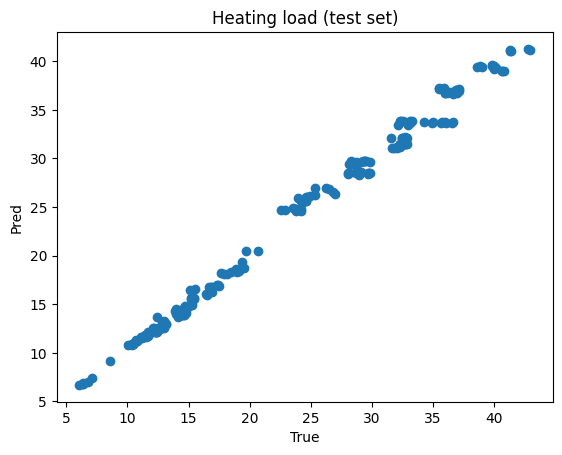

In [19]:
# prediction on heating load (y1)
y_pred1 = final_model_y1.predict(X_test1)
plt.scatter(y_test1, y_pred1)
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Heating load (test set)")

Text(0.5, 1.0, 'Cooling load (test set)')

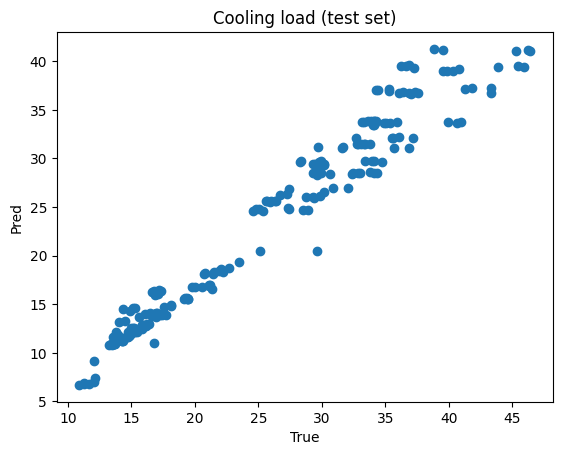

In [20]:
# prediction on cooling load (y2)
y_pred2 = final_model_y2.predict(X_test2)
plt.scatter(y_test2, y_pred2)
plt.xlabel("True")
plt.ylabel("Pred")
plt.title("Cooling load (test set)")